In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import numpy as np

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [2]:
df=pd.read_csv('Womens_Clothing_E_Commerce_Reviews.csv')

In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.dtypes

Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [5]:
df.shape

(23486, 11)

# Data analysis and Data cleaning

In [6]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [7]:
df.isnull().sum(axis=0)

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [8]:
df.fillna('0',axis=1,inplace=True)
df.isnull().sum(axis=0)

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

##  Classifying the ratings into Good and Bad

In [9]:
df['Rating_Class']='Bad'
df.loc[df['Rating']>3,['Rating_Class']]='Good'
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Rating_Class
0,767,33,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Good
1,1080,34,0,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Good
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Bad
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Good
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Good


In [10]:
df.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


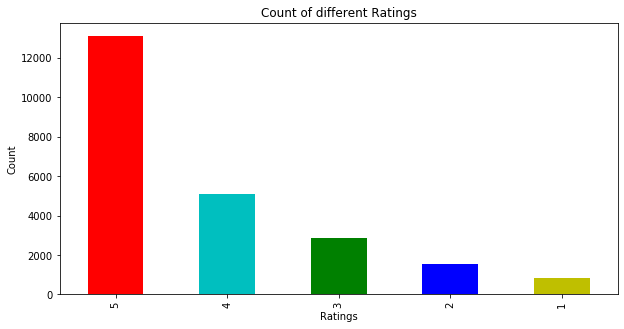

In [11]:
ratingCount=pd.value_counts(df['Rating']).sort_index(ascending=False)
grph1=ratingCount.plot(kind='bar',title='Count of different Ratings',figsize=(10,5),color=list('rcgby'))
grph1.set(xlabel='Ratings',ylabel='Count');

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Rating Class')]

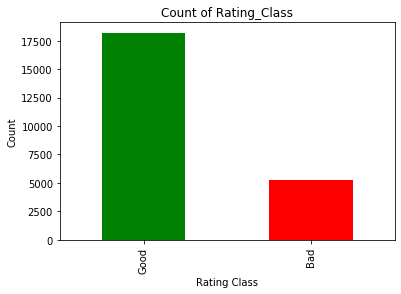

In [12]:
classCount=pd.value_counts(df['Rating_Class'])
grph2=classCount.plot(kind='bar',title='Count of Rating_Class',color=list('gr'))
grph2.set(xlabel='Rating Class',ylabel='Count')

In [13]:
goodrating=df.loc[df['Rating_Class']=='Good']
badrating=df.loc[df['Rating_Class']=='Bad']

Printing top 10 Clothing ID's with good as Rating Class

In [14]:
pd.value_counts(goodrating['Clothing ID'])[:10].rename_axis('Clothing ID').reset_index(name='Counts')

,Clothing ID,Counts
0,1078,796
1,862,627
2,1094,584
3,1081,471
4,872,459
5,829,406
6,1110,377
7,895,323
8,868,295
9,936,285


Printing top 10 Clothing ID's with good as Rating Class

In [15]:
pd.value_counts(badrating['Clothing ID'])[:10].rename_axis('Clothing ID').reset_index(name='Counts')

,Clothing ID,Counts
0,1078,228
1,862,179
2,1094,172
3,868,135
4,829,121
5,1081,111
6,1110,103
7,1095,88
8,872,86
9,867,84


We can observe that Clothing ID doesn't help us classifying data. Since,we can see some similar Clothing IDs in both tables.

  
### Grouping the Age of Reviewers


In [16]:
df.loc[((df['Age'] >=18) & (df['Age'] <=25)),'Age_Group'] = '18-25'
df.loc[((df['Age'] >25) & (df['Age'] <=30)),'Age_Group'] = '26-30'
df.loc[((df['Age'] >30) & (df['Age'] <=40)),'Age_Group'] = '31-40'
df.loc[((df['Age'] >41) & (df['Age'] <=50)),'Age_Group'] = '41-50'
df.loc[((df['Age'] >50) & (df['Age'] <=60)),'Age_Group'] = '51-60'
df.loc[((df['Age'] >60) & (df['Age'] <=70)),'Age_Group'] = '61-70'
df.loc[((df['Age'] >70) & (df['Age'] <=100)),'Age_Group'] = '71-100'

In [17]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Rating_Class,Age_Group
0,767,33,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Good,31-40
1,1080,34,0,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Good,31-40
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Bad,51-60
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Good,41-50
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Good,41-50


In [18]:
ratings_count = df.groupby(['Rating', df['Age_Group']]).size().reset_index(name='n')
df.columns

ratings_count_pivot = pd.pivot_table(ratings_count,index=["Age_Group"],
               values=["n"],
               columns=["Rating"],
               aggfunc=[np.sum])

ratings_count_pivot

sum                       
             n                       
Rating       1    2     3     4     5
Age_Group                            
18-25       36   59   137   270   721
26-30       78  155   309   436  1137
31-40      280  564  1014  1752  4302
41-50      199  376   661  1165  2766
51-60      149  233   411   817  2281
61-70       75  106   216   408  1252
71-100      15   28    35    65   237

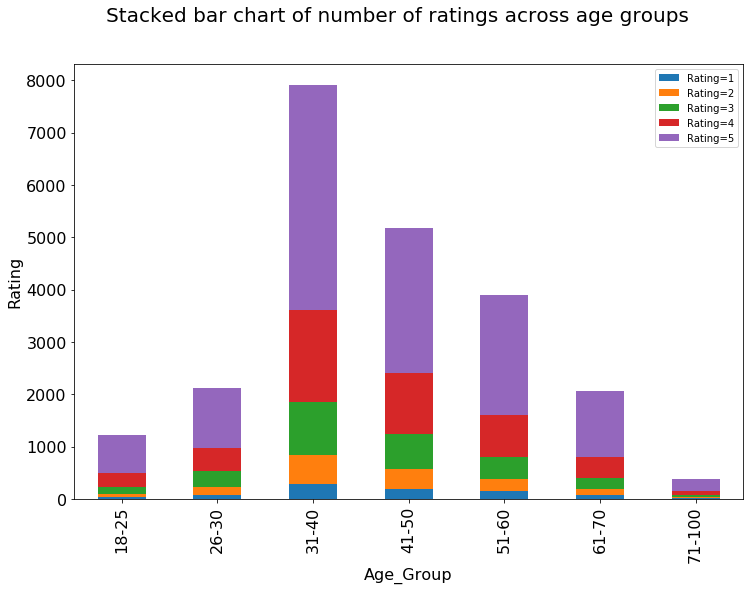

In [19]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)

ratings_count_pivot.plot(kind = 'bar', stacked=True, fontsize = 16, ax=ax,)
ax.set_ylabel("Rating", fontsize=16)
ax.set_xlabel("Age_Group", fontsize=16)
ax.legend(["Rating=1", "Rating=2","Rating=3","Rating=4","Rating=5"])
fig.suptitle('Stacked bar chart of number of ratings across age groups', fontsize=20)
plt.show()

Conclusion: Women in the 30s to 40s give the most number of online reviews, followed by women in the 30s to 40s, 50s to 60s then young women in their 20s to 30s . This is surprising, given that e-commerce sites tend to be more popular among young women. Perhaps youngsters shop online but do not provide their ratings, thus these people are not captured in dataset.  
  
The most common rating given is 5 across women from ages 20 to 70. While this could mean the e-commerce company may be doing a good job at providing a good shopping experience for their customers, analysing the sentiments of the customers' reviews will tell us a more holistic story.
  
  

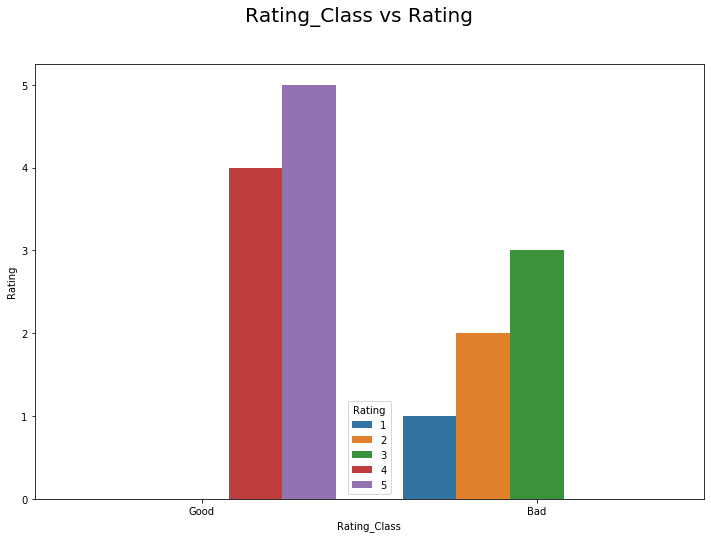

In [20]:
fig1=plt.figure(figsize=(12,8))
sns.barplot(data=df,y='Rating',x='Rating_Class',hue='Rating')
fig1.suptitle('Rating_Class vs Rating', fontsize=20);

In [21]:
divisonCount=pd.value_counts(df['Division Name'])
departmentCount=pd.value_counts(df['Department Name'])
ClassnameCount=pd.value_counts(df['Class Name'])

Ploting the graph of Number of ratings given different Division Names.

[Text(0, 0.5, 'Number of Ratings given / Number of Cloths'),
 Text(0.5, 0, 'Division Name')]

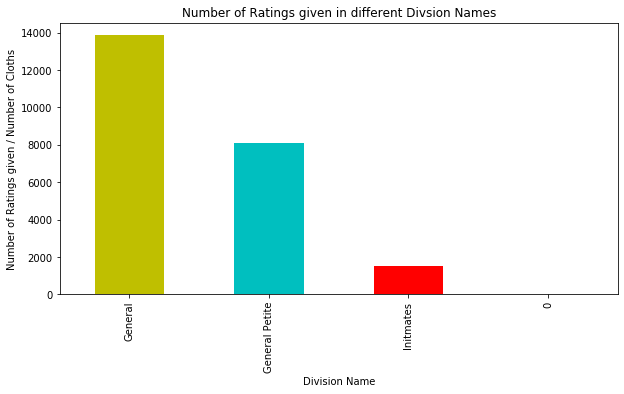

In [22]:
grph=divisonCount.plot(kind='bar',title='Number of Ratings given in different Divsion Names',figsize=(10,5),color=list('ycr'))
grph.set(xlabel='Division Name',ylabel='Number of Ratings given / Number of Cloths')

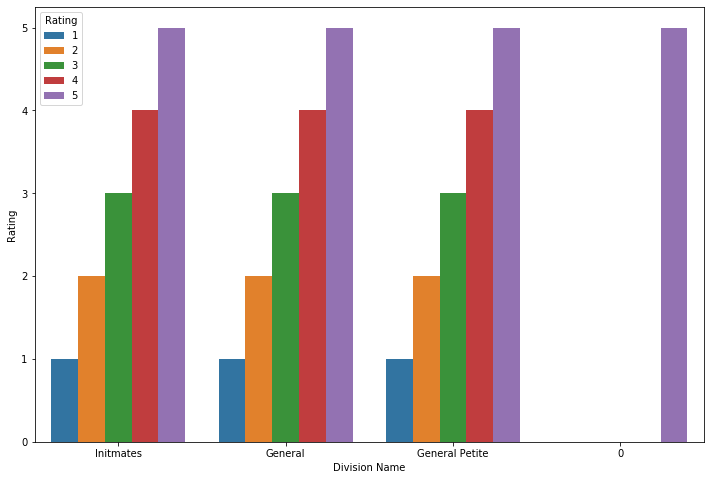

In [23]:
plt.figure(figsize=(12,8))
sns.barplot(data=df,x='Division Name',y='Rating',hue='Rating');

From the graph we can see that Ratings given in different Division Names is almost similar.

[Text(0, 0.5, 'Number of Ratings given / Number of Cloths'),
 Text(0.5, 0, 'Department Name')]

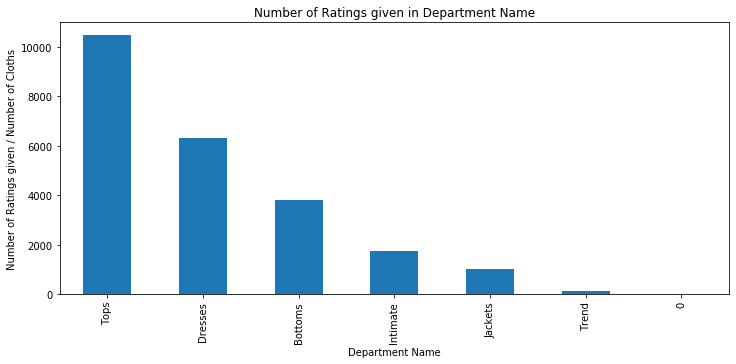

In [24]:
graph=departmentCount.plot(kind='bar',title='Number of Ratings given in Department Name',figsize=(12,5))
graph.set(xlabel='Department Name',ylabel='Number of Ratings given / Number of Cloths')

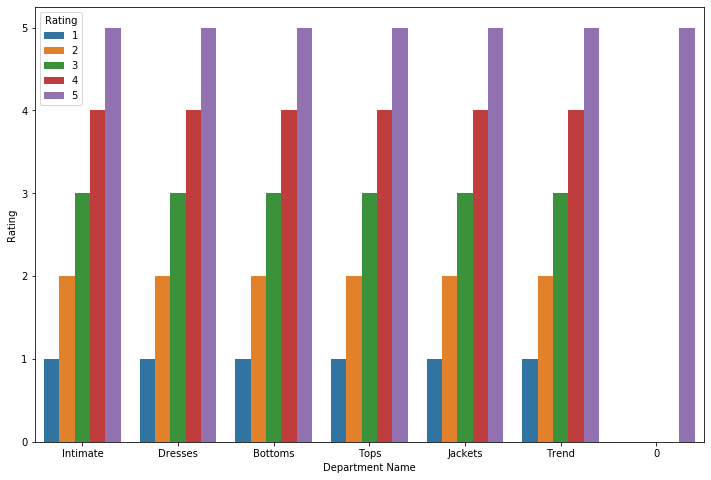

In [25]:
plt.figure(figsize=(12,8))
sns.barplot(data=df,x='Department Name',y='Rating',hue='Rating');

From the graph we can see that Ratings given in Department Names is almost similar.

[Text(0, 0.5, 'Number of cloths'), Text(0.5, 0, 'Class Name')]

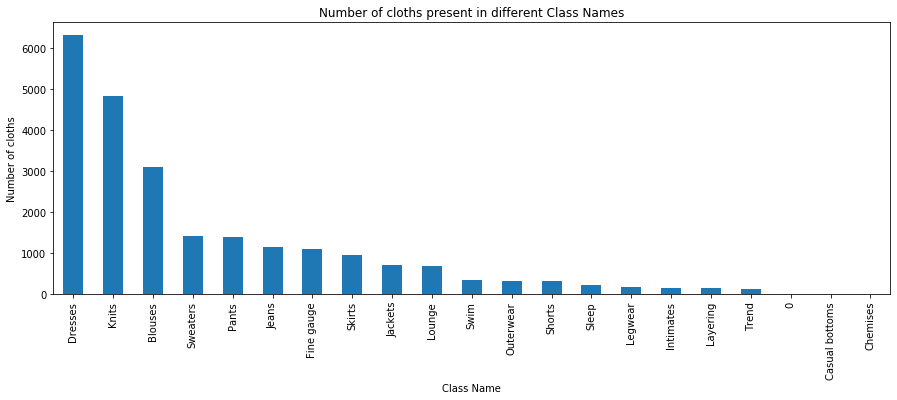

In [26]:
graph1=ClassnameCount.plot(kind='bar',title='Number of cloths present in different Class Names',figsize=(15,5))
graph1.set(xlabel='Class Name',ylabel='Number of cloths')

Comparing Recommended IND with Rating.

In [27]:
goodrecmdIND=pd.value_counts(goodrating['Recommended IND'])
badrecmdIND=pd.value_counts(badrating['Recommended IND'])

[(0, 5)]

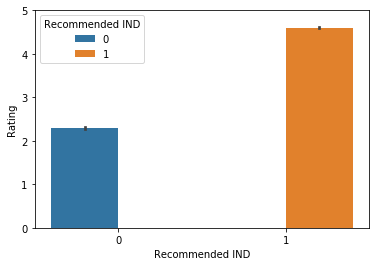

In [28]:
ag = sns.barplot(data=df,x='Recommended IND',y='Rating',hue='Recommended IND')
ag.set(ylim=(0,5))

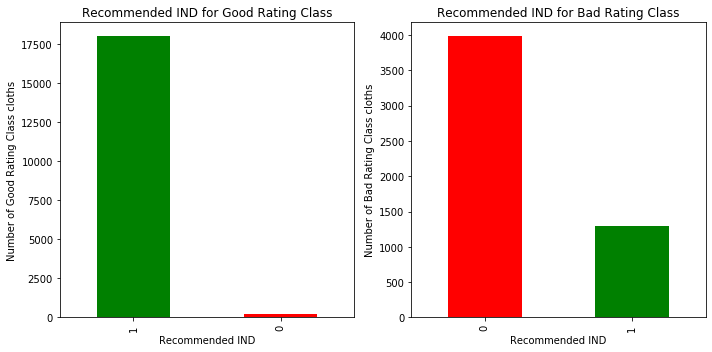

In [29]:
plt.figure(1)
plt.subplot(1,2,1)
graph2=goodrecmdIND.plot(kind='bar',title='Recommended IND for Good Rating Class',color=list('gr'),figsize=(10,5))
graph2.set(xlabel='Recommended IND',ylabel='Number of Good Rating Class cloths')
plt.figure(1)
plt.subplot(1,2,2)
graph3=badrecmdIND.plot(kind='bar',title='Recommended IND for Bad Rating Class',color=list('rg'),figsize=(10,5))
graph3.set(xlabel='Recommended IND',ylabel='Number of Bad Rating Class cloths')
plt.tight_layout()

From the above graphs we can see that Recommended IND is 1 for most of the Good Rating Class products and Recommended IND is 0 for Bad Rating Class products. So,Recommended IND will be help in data analysis.

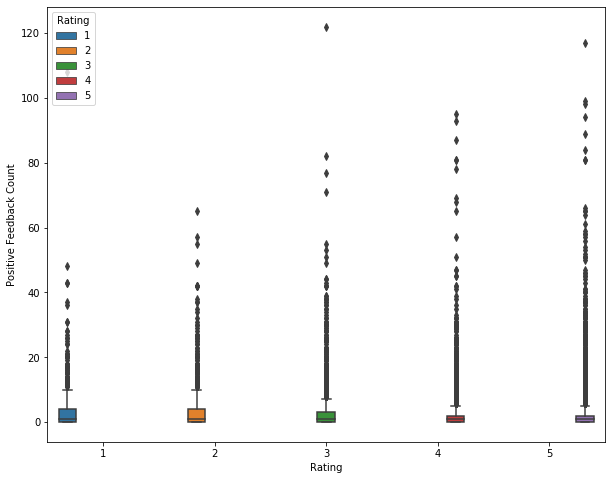

In [30]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df,x='Rating',y='Positive Feedback Count',hue='Rating')

# Text normalisation on Review Text

In [31]:
def string(r):
    #removing regular expressions and changing to lowercase
    r1 = re.sub('[^A-Za-z]+', ' ', str(r))
    r1 = r1.strip().lower()
   
    #removing stopwords
    number_of_stopwords = []
    if r1 not in stopwords.words():
        number_of_stopwords.append(r1)
        
   #performing stemming
    stemmer = PorterStemmer() 
    final_list = []

    for i in number_of_stopwords:
        final_list.append(stemmer.stem(str(i)))
                
    return final_list

In [32]:
df['Filtered_Reviews'] = df['Review Text'].apply(string)

In [33]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Rating_Class,Age_Group,Filtered_Reviews
0,767,33,0,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Good,31-40,[absolutely wonderful silky and sexy and comfort]
1,1080,34,0,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Good,31-40,[love this dress it s sooo pretty i happened t...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Bad,51-60,[i had such high hopes for this dress and real...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,Good,41-50,[i love love love this jumpsuit it s fun flirt...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Good,41-50,[this shirt is very flattering to all due to t...


In [34]:
data=df.copy()
data=data[['Review Text','Rating','Age_Group','Recommended IND','Filtered_Reviews']]
data.head()

,Review Text,Rating,Age_Group,Recommended IND,Filtered_Reviews
0,Absolutely wonderful - silky and sexy and comf...,4,31-40,1,[absolutely wonderful silky and sexy and comfort]
1,Love this dress! it's sooo pretty. i happene...,5,31-40,1,[love this dress it s sooo pretty i happened t...
2,I had such high hopes for this dress and reall...,3,51-60,0,[i had such high hopes for this dress and real...
3,"I love, love, love this jumpsuit. it's fun, fl...",5,41-50,1,[i love love love this jumpsuit it s fun flirt...
4,This shirt is very flattering to all due to th...,5,41-50,1,[this shirt is very flattering to all due to t...


# Sentiment analysis on Filtered reviews

In [35]:
sid = SentimentIntensityAnalyzer()
num_records = data.shape[0]
ones_array = np.ones(num_records)
pd.options.display.float_format = '{:.2f}'.format
    
data['Compound score'] = ones_array
for i in range(len(data['Filtered_Reviews'])):

    element = data['Filtered_Reviews'].iloc[i][0]
    score = sid.polarity_scores(element)
    compound = score['compound']
    data['Compound score'].iloc[i] = compound
data.head()



G:\anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Review Text,Rating,Age_Group,Recommended IND,Filtered_Reviews,Compound score
0,Absolutely wonderful - silky and sexy and comf...,4,31-40,1,[absolutely wonderful silky and sexy and comfort],0.87
1,Love this dress! it's sooo pretty. i happene...,5,31-40,1,[love this dress it s sooo pretty i happened t...,0.97
2,I had such high hopes for this dress and reall...,3,51-60,0,[i had such high hopes for this dress and real...,0.94
3,"I love, love, love this jumpsuit. it's fun, fl...",5,41-50,1,[i love love love this jumpsuit it s fun flirt...,0.72
4,This shirt is very flattering to all due to th...,5,41-50,1,[this shirt is very flattering to all due to t...,0.92


In [36]:
sort_data=data.sort_values('Age_Group')

Text(0.5, 1.0, 'Boxplot of compound sentiment score across age groups')

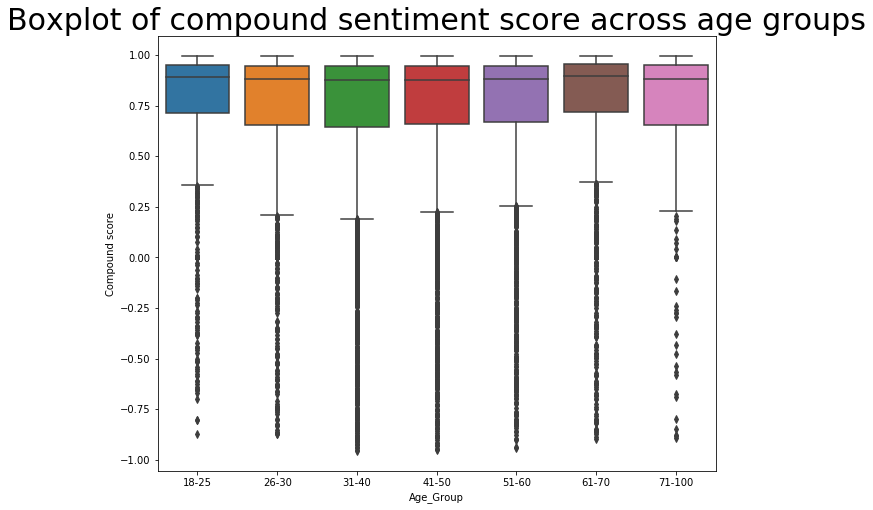

In [38]:
plt.figure(figsize=(10,8))
datavis1 = sns.boxplot(data=sort_data,x='Age_Group',y='Compound score')
datavis1.set_title('Boxplot of compound sentiment score across age groups',fontsize=30)

Conclusion: Women across all age groups have given very positive sentiments about their shopping experience, with a general compound polarity of 0.9. However, there are more outliers in sentiment scores amongst women from 20s to 70s.

# Classify sentiments into Positive, Negative or Neutral

In [37]:
data.loc[data['Compound score'] > 0, 'Sentiment category'] = 'Positive'
data.loc[data['Compound score'] == 0, 'Sentiment category'] = 'Neutral'
data.loc[data['Compound score'] < 0, 'Sentiment category'] = 'Negative'
data.head(20)

,Review Text,Rating,Age_Group,Recommended IND,Filtered_Reviews,Compound score,Sentiment category
0,Absolutely wonderful - silky and sexy and comf...,4,31-40,1,[absolutely wonderful silky and sexy and comfort],0.87,Positive
1,Love this dress! it's sooo pretty. i happene...,5,31-40,1,[love this dress it s sooo pretty i happened t...,0.97,Positive
2,I had such high hopes for this dress and reall...,3,51-60,0,[i had such high hopes for this dress and real...,0.94,Positive
3,"I love, love, love this jumpsuit. it's fun, fl...",5,41-50,1,[i love love love this jumpsuit it s fun flirt...,0.72,Positive
4,This shirt is very flattering to all due to th...,5,41-50,1,[this shirt is very flattering to all due to t...,0.92,Positive
5,"I love tracy reese dresses, but this one is no...",2,41-50,0,[i love tracy reese dresses but this one is no...,0.94,Positive
6,I aded this in my basket at hte last mintue to...,5,31-40,1,[i aded this in my basket at hte last mintue t...,0.46,Positive
7,"I ordered this in carbon for store pick up, an...",4,31-40,1,[i ordered this in carbon for store pick up an...,-0.09,Negative
8,I love this dress. i usually get an xs but it ...,5,18-25,1,[i love this dress i usually get an xs but it ...,0.72,Positive
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,31-40,1,[i m and lbs i ordered the s petite to make su...,-0.37,Negative


# Number of sentiment categories


In [39]:
sentiments = data.copy()
sentiments = sentiments[[ 'Sentiment category']]
N_O_S = sentiments.groupby('Sentiment category').size().reset_index(name='No. of sentiments')
N_O_S

,Sentiment category,No. of sentiments
0,Negative,1278
1,Neutral,998
2,Positive,21210


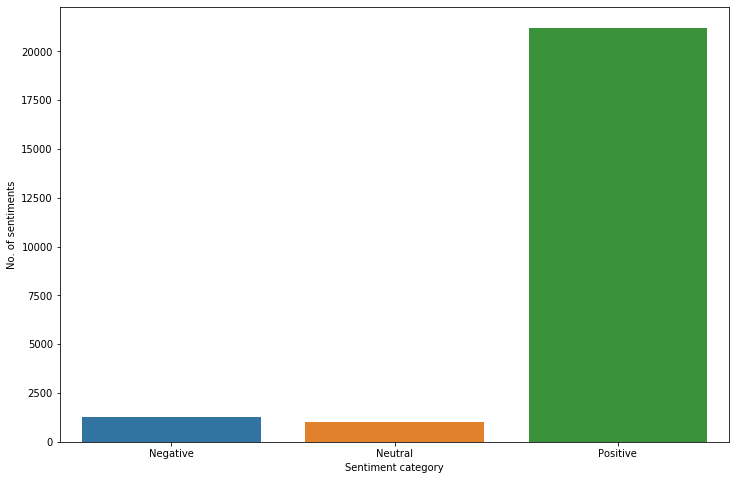

In [40]:
plt.figure(figsize=(12,8))
sns.barplot(data=N_O_S,x='Sentiment category',y='No. of sentiments')

Given that there are a lot more positive reviews, the list of popular items found earlier should reflect positive sentiments about their purchase. The company can consider manufacturing or bringing in more of such type of apparels.

The large proportion of positive reviews also corresponds with the greater proportion of maximum (5/5) ratings given.

Wordcloud for each category of sentiments

In [41]:
positive_reviews = data.loc[data['Sentiment category']=='Positive', 'Filtered_Reviews'].tolist()
psv_rev_desc = ''
for i in positive_reviews:
    for x in i:
        psv_rev_desc = psv_rev_desc + '' + x  



# Word Cloud

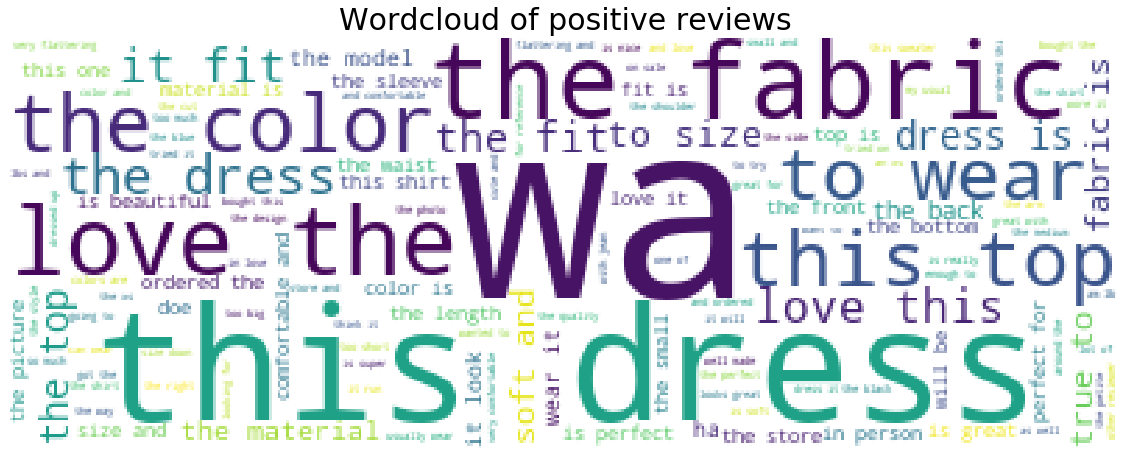

In [42]:
fig = plt.figure(figsize=(20,10))
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(psv_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of positive reviews", fontsize=30)
plt.show()

In [43]:
negative_reviews = data.loc[data['Sentiment category']=='Negative', 'Filtered_Reviews'].tolist()
neg_rev_desc = ''
for i in negative_reviews:
    for x in i:
        neg_rev_desc = neg_rev_desc + '' + x  

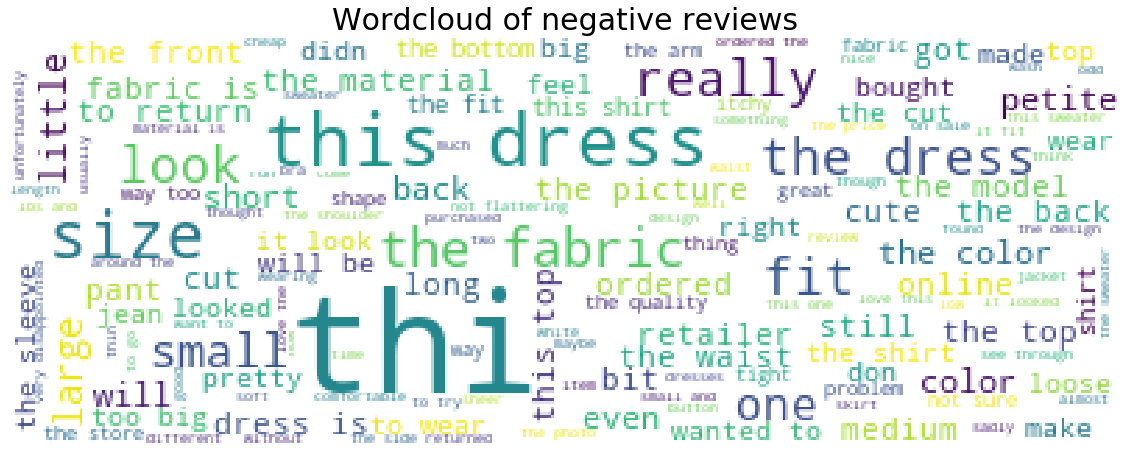

In [44]:
fig = plt.figure(figsize=(20,10))
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(neg_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of negative reviews", fontsize=30)
plt.show()

In [45]:
neutral_reviews = data.loc[data['Sentiment category']=='Neutral', 'Filtered_Reviews'].tolist()
neu_rev_desc = ''
for i in neutral_reviews:
    for x in i:
        neu_rev_desc = neu_rev_desc + '' + x  

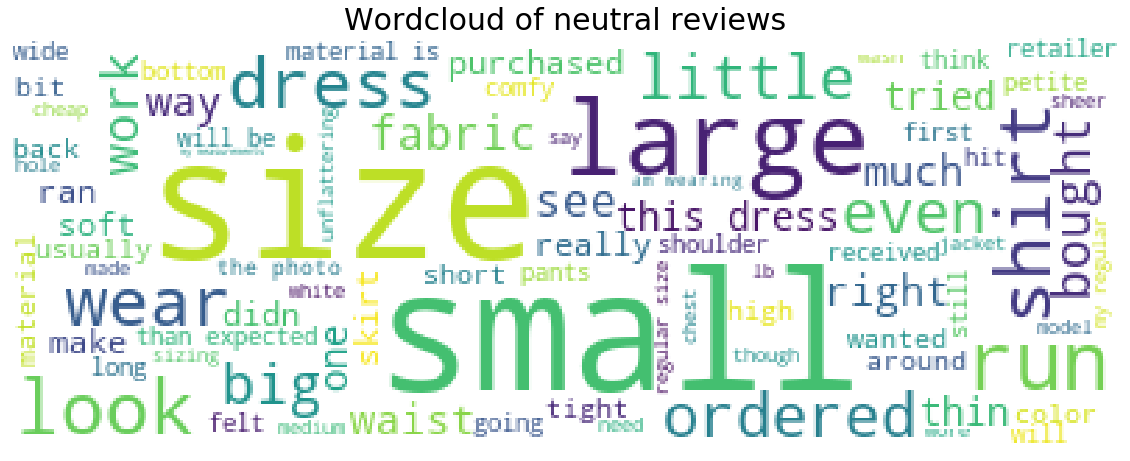

In [46]:
fig = plt.figure(figsize=(20,10))
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(neu_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of neutral reviews", fontsize=30)
plt.show()

# Apply the Machine Learning Algorithms on Sentiment category to predict if item is recommended

# Train

In [47]:
X = data['Sentiment category']
y = data['Recommended IND']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=17)


# Apply CountVectorizer and TdidfTransformer transformations

In [48]:
count_vect = CountVectorizer()
tfidf_tfm = TfidfTransformer()
train_data1_counts = count_vect.fit_transform(X_train)
train_data1_tfidf = tfidf_tfm.fit_transform(train_data1_counts)

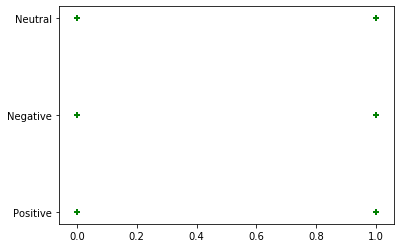

In [50]:
sc = plt.scatter(x = data['Recommended IND'],y=data['Sentiment category'],color='green',marker='+')

The above graph is linearly separable

# Fit the model using K-Nearest Neighbor

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import metrics
clf = neighbors.KNeighborsClassifier()
clf.fit(train_data1_tfidf,y_train)
print(clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


# Test

In [52]:
y_expect = y_test
count_test_vect = count_vect.transform(X_test)
y_pred = clf.predict(count_test_vect)
print(metrics.classification_report(y_expect,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.21      0.31       848
           1       0.85      0.98      0.91      3850

    accuracy                           0.84      4698
   macro avg       0.75      0.59      0.61      4698
weighted avg       0.81      0.84      0.80      4698



 Conclusion : The Total Accuracy is 84%

# Fit the model using support vector machine

In [53]:
from sklearn.svm import SVC
model = SVC(C=100)

In [54]:
model.fit(train_data1_tfidf,y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
print('Accuracy:',model.score(count_test_vect,y_test))

Accuracy: 0.8367390378884632


Conclusion : The accuracy is 83.6 %


# Fit the model using Naïve Bayes Classification

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_data1_tfidf, y_train)

print('Accuracy:',clf.score(count_test_vect,y_test))

Accuracy: 0.8367390378884632


Conclusion : The accuracy is 83.6%

# Evaluate Model
Compare results in predicted model against the original results


In [57]:
y_confusion_data = pd.DataFrame({"y_test": y_test, "y_predict" : y_pred} )
y_confusion_data.head()

,y_test,y_predict
3948,0,1
631,1,1
21020,1,0
12874,0,1
12873,1,1


In [58]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 174,  674],
       [  93, 3757]], dtype=int64)

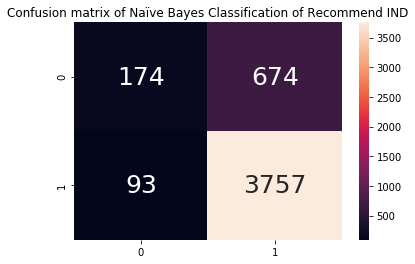

In [59]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of Naïve Bayes Classification of Recommend IND")
plt.show()

In [60]:
print("True negatives:", (cm[0][0]))
print("True positives:", (cm[1][1]))
print("False negatives:", (cm[0][1]))
print("Total:", (sum(sum(cm))))
print("Accuracy:", ((cm[0][0] + cm[1][1])/sum(sum(cm))))
print("Proportion of False negatives:", (cm[0][1] /sum(sum(cm))))

True negatives: 174
True positives: 3757
False negatives: 674
Total: 4698
Accuracy: 0.8367390378884632
Proportion of False negatives: 0.14346530438484462


Conclusion: Accuracy of model is 83.6%

More importantly, 17.3 % of the time, the model wrongly predicts that a customer would recommend her product based on her sentiments, when she actually would not have

# Finding Mismatch Data

In [61]:
data['id'] = data.index
y_confusion_data['id'] = y_confusion_data.index

wrong_indices = y_confusion_data[
    y_confusion_data['y_test'] != y_confusion_data['y_predict']].index

mismatch_data = data.merge(y_confusion_data, on='id')
mismatch_data = mismatch_data[mismatch_data['id'].isin(wrong_indices)]
mismatch_data.head()

,Review Text,Rating,Age_Group,Recommended IND,Filtered_Reviews,Compound score,Sentiment category,id,y_test,y_predict
3,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,31-40,1,[i m and lbs i ordered the s petite to make su...,-0.37,Negative,9,1,0
4,"Loved the material, but i didnt really look at...",3,31-40,0,[loved the material but i didnt really look at...,0.92,Positive,25,0,1
5,I have been waiting for this sweater coat to s...,2,31-40,0,[i have been waiting for this sweater coat to ...,0.48,Positive,26,0,1
7,"I ordered this 3 months ago, and it finally ca...",2,31-40,0,[i ordered this months ago and it finally came...,0.73,Positive,33,0,1
16,I am pregnant and i thought this would be a gr...,2,31-40,0,[i am pregnant and i thought this would be a g...,0.86,Positive,56,0,1


In [62]:
mismatch_sample = mismatch_data.iloc[4]['Filtered_Reviews']
mismatch_sample

['i am pregnant and i thought this would be a great sleep bra it s soft and fits okay but it has zero support or shape i would only buy if you are a b cup or smaller and can get away without support if i would have seen this is the store i would have passed over it however i was too lazy to return so i am wearing it it s comfortable so that s a redeeming quality i would not recommend for larger chested ladies though']

In [63]:
spl = mismatch_data.sample()
print(spl[[ 'id','Sentiment category','y_test','y_predict']])
print()
print(spl.iloc[0]['Filtered_Reviews'])

       id Sentiment category  y_test  y_predict
296  1464           Positive       0          1

['you have to be a contortionist to get this bra on it slips over your head and i needed my yo daughter to help me pull it down past my elbows ridiculously impractical why oh why didn t heather give it a hook and loop closure instead']


The above sample shows how the model wrongly predicts that a customer would not recommend her product based on her sentiments, when she actually would recommend. Hence the model should be interpreted and used with caution.